# Imports

In [78]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import optuna 

import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn import metrics

# Helper functions and MLP class

In [79]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, activation_function, dropout_rate, use_batch_norm=True):
        super(MLP, self).__init__()
        self.activation_function = activation_function
        self.dropout = nn.Dropout(p=dropout_rate)
        self.use_batch_norm = use_batch_norm

        layers_dims = [input_size] + hidden_layers + [num_classes]
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()

        for i in range(len(layers_dims) - 1):  
            self.layers.append(nn.Linear(layers_dims[i], layers_dims[i+1]))
            
            if use_batch_norm and i < len(layers_dims) - 2:
                self.batch_norms.append(nn.BatchNorm1d(layers_dims[i+1]))



    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation_function(layer(x))
            x = self.dropout(x)

        x = self.layers[-1](x)
        
        return x 

In [92]:
def get_scores(targets, predictions):
    return {
        "accuracy"         : metrics.accuracy_score(targets, predictions),
        "balanced_accuracy": metrics.balanced_accuracy_score(targets, predictions),
        "f1_score"         : metrics.f1_score(targets, predictions, average="weighted"),
        "precision"        : metrics.precision_score(targets, predictions, average="weighted"),
        "recall"           : metrics.recall_score(targets, predictions, average="weighted"),
        "f1_score"         : metrics.f1_score(targets, predictions, average="weighted")
    }

def evaluate_model(model, data_loader, loss_function):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.view(-1, 32*32*3).cuda()
            labels = labels.cuda()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            total_loss += loss.item()

    return total_loss / len(data_loader)

def show_loss_through_epochs(arr_losses_train, arr_losses_test, arr_losses_val):
    plt.plot(arr_losses_train, label = "train loss")
    plt.plot(arr_losses_val, label = "val loss")
    plt.plot(arr_losses_test, label = "test loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid()
    plt.legend()
    return None

def show_predictions(model, dataloader, num_samples):
    model.eval()
    correct_samples = []
    wrong_samples = []

    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
    
    with torch.no_grad():
        for images, labels in dataloader:
            original_images = images

            images = images.view(-1, 32*32*3).cuda()
            labels = labels.cuda()

            outputs = model.forward(images)
            _, predicted = torch.max(outputs.data, 1)

            for i in range(len(labels)):
                pred = predicted[i].cpu().item()
                true = labels[i].cpu().item()
                img = original_images[i]

                if pred == true and len(correct_samples) < num_samples:
                    correct_samples.append((img, pred, true))
                elif pred != true and len(wrong_samples) < num_samples:
                    wrong_samples.append((img, pred, true))

                if len(correct_samples) >= num_samples and len(wrong_samples) >= num_samples:
                    break

    plt.figure(figsize=(24, 20))
    
    plt.subplot(1, 2, 1)
    # acertos
    for idx, (img, pred, true) in enumerate(correct_samples):
        plt.subplot(2, num_samples, idx + 1)
        img = img.permute(1, 2, 0)  
        img = img * 0.5 + 0.5 
        plt.imshow(img)
        plt.title(f'Correto!\nPred: {classes[pred]}\nTrue: {classes[true]}')
        plt.axis('off')

    # erros
    for idx, (img, pred, true) in enumerate(wrong_samples):
        plt.subplot(2, num_samples, idx + num_samples + 1)
        img = img.permute(1, 2, 0)
        img = img * 0.5 + 0.5
        plt.imshow(img)
        plt.title(f'Erro!\nPred: {classes[pred]}\nTrue: {classes[true]}')
        plt.axis('off')
    
    plt.tight_layout(h_pad=2)
    plt.show()

    return None

def objective(trial):
    global train_dataset_global, validation_dataset_global

    activation_name = trial.suggest_categorical('activation', ['ReLU', 'Sigmoid', 'Tanh'])
    activation_functions = {
        'ReLU': nn.ReLU(),
        'Sigmoid': nn.Sigmoid(),
        'Tanh': nn.Tanh()
    }
    activation_function = activation_functions[activation_name]
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_int('batch_size', 32, 512)

    # reg params
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    use_batch_norm = trial.suggest_categorical('use_batch_norm', [True, False])

    n_layers = trial.suggest_int('n_layers', 2, 7)
    hidden_layers = []
    for i in range(n_layers):
        n_units = trial.suggest_int(f'n_units_l{i}', 32, 256)
        hidden_layers.append(n_units)

    input_size = 32*32*3
    num_classes = 10
    loss_function = nn.CrossEntropyLoss()
    
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset_global, 
        batch_size=batch_size, 
        shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        dataset=validation_dataset_global, 
        batch_size=batch_size, 
        shuffle=False
    )

    model = MLP(
        input_size=input_size,
        hidden_layers=hidden_layers,
        num_classes=num_classes,
        activation_function=activation_function,
        dropout_rate=dropout_rate,
        use_batch_norm=use_batch_norm
    ).cuda()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    best_val_loss = float('inf')
    patience = 7
    patience_counter = 0
    
    for _ in range(50):
        model.train()
        for images, labels in train_loader:
            images = images.view(-1, input_size).cuda()
            labels = labels.cuda()
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
        
        model.eval() # disable dropout just to validate
        val_loss = evaluate_model(model, val_loader, loss_function)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            break
    
    return best_val_loss


# Setup

In [89]:
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                    ])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [82]:
# # just to run fast
# subset_sample      = 1000

# train_dataset      = torch.utils.data.Subset(train_dataset, range(subset_sample))
# validation_dataset = torch.utils.data.Subset(validation_dataset, range(subset_sample))
# test_dataset       = torch.utils.data.Subset(test_dataset, range(subset_sample))


In [90]:
train_dataset_global = train_dataset
validation_dataset_global = validation_dataset

# Def hyperparameters and Loaders

In [93]:
loss_function       = nn.CrossEntropyLoss()

# Main training Loop

## Optuna optimization

In [94]:
n_trials=50
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=n_trials)

[I 2025-06-01 10:29:54,819] A new study created in memory with name: no-name-3fca49fc-eb3e-419e-bc25-7f1cbcfbc8a8
[I 2025-06-01 10:32:35,695] Trial 0 finished with value: 1.7530816596942944 and parameters: {'activation': 'Sigmoid', 'learning_rate': 2.367323233549144e-05, 'batch_size': 110, 'dropout_rate': 0.4804417216026607, 'weight_decay': 0.0002838565316561642, 'use_batch_norm': True, 'n_layers': 2, 'n_units_l0': 120, 'n_units_l1': 251}. Best is trial 0 with value: 1.7530816596942944.
[I 2025-06-01 10:35:05,898] Trial 1 finished with value: 1.7354811712315208 and parameters: {'activation': 'Tanh', 'learning_rate': 8.827590629900311e-05, 'batch_size': 269, 'dropout_rate': 0.3813437992896945, 'weight_decay': 0.005109005939802738, 'use_batch_norm': True, 'n_layers': 6, 'n_units_l0': 248, 'n_units_l1': 33, 'n_units_l2': 174, 'n_units_l3': 89, 'n_units_l4': 72, 'n_units_l5': 37}. Best is trial 1 with value: 1.7354811712315208.
[I 2025-06-01 10:36:44,843] Trial 2 finished with value: 1.310

## Best founded model

In [95]:
study.best_params

{'activation': 'ReLU',
 'learning_rate': 0.00015022702893239146,
 'batch_size': 135,
 'dropout_rate': 0.3805683424052424,
 'weight_decay': 6.643296698414264e-05,
 'use_batch_norm': True,
 'n_layers': 2,
 'n_units_l0': 254,
 'n_units_l1': 108}

In [96]:
hidden_layers = [study.best_params[f'n_units_l{i}'] for i in range(study.best_params['n_layers'])]

activation_functions = {
    'ReLU': nn.ReLU(),
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh()
}

best_activation = activation_functions[study.best_params['activation']]

# reg params
dropout_rate=study.best_params['dropout_rate']
use_batch_norm=study.best_params['use_batch_norm']

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset_global, 
    batch_size=study.best_params['batch_size'], 
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset=validation_dataset_global, 
    batch_size=study.best_params['batch_size'], 
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=study.best_params['batch_size'], 
    shuffle=False
)


In [97]:
mlp = MLP(
    input_size=32*32*3,
    hidden_layers=hidden_layers,
    num_classes=10,
    activation_function=best_activation,
    dropout_rate=dropout_rate,
    use_batch_norm=use_batch_norm
)
# mlp.cpu()
mlp.cuda()

optimizer = torch.optim.Adam(mlp.parameters(), 
                             lr=study.best_params['learning_rate'], 
                             weight_decay=study.best_params['weight_decay'])

best_val_loss = float('inf')
patience = 5
patience_counter = 0

arr_losses_train = []
arr_losses_test  = []
arr_losses_val   = []

# main loop
num_epochs       = 10000
for epoch in tqdm(range(num_epochs)):
    mlp.train()
    epoch_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 32*32*3).cuda()
        labels = labels.cuda()
        optimizer.zero_grad()

        # forward pass
        outputs = mlp.forward(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if (i+1) % 1000 == 0:
            tqdm.write(f' Epoch {epoch + 1}/{num_epochs}, Step {i+1}/{len(train_dataset) // study.best_params['batch_size']}, Loss: {loss}')

    mlp.eval()
    train_loss = epoch_loss/len(train_loader)
    val_loss   = evaluate_model(mlp, val_loader, loss_function)
    test_loss  = evaluate_model(mlp, test_loader, loss_function)

    arr_losses_train.append(train_loss)
    arr_losses_val.append(val_loss)
    arr_losses_test.append(test_loss)

    tqdm.write(f'Epoch {epoch+1}:')
    tqdm.write(f'Train Loss: {train_loss:.4f}')
    tqdm.write(f'Val Loss: {val_loss:.4f}')
    tqdm.write(f'Test Loss: {test_loss:.4f}')


    # early stopping 
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0

    else:
        patience_counter += 1
        if patience_counter >= patience:
            tqdm.write("early stopping based on loss reduction when we compare to val dataset")
            break



  0%|          | 1/10000 [00:04<11:06:44,  4.00s/it]

Epoch 1:
Train Loss: 1.9410
Val Loss: 1.7180
Test Loss: 1.7078


  0%|          | 2/10000 [00:07<10:59:59,  3.96s/it]

Epoch 2:
Train Loss: 1.7424
Val Loss: 1.6265
Test Loss: 1.6045


  0%|          | 3/10000 [00:11<11:07:03,  4.00s/it]

Epoch 3:
Train Loss: 1.6706
Val Loss: 1.5736
Test Loss: 1.5566


  0%|          | 4/10000 [00:15<11:05:57,  4.00s/it]

Epoch 4:
Train Loss: 1.6240
Val Loss: 1.5378
Test Loss: 1.5168


  0%|          | 5/10000 [00:19<11:05:48,  4.00s/it]

Epoch 5:
Train Loss: 1.5837
Val Loss: 1.5048
Test Loss: 1.4847


  0%|          | 6/10000 [00:23<10:53:45,  3.92s/it]

Epoch 6:
Train Loss: 1.5570
Val Loss: 1.4820
Test Loss: 1.4612


  0%|          | 7/10000 [00:27<10:45:44,  3.88s/it]

Epoch 7:
Train Loss: 1.5271
Val Loss: 1.4591
Test Loss: 1.4373


  0%|          | 8/10000 [00:31<10:40:41,  3.85s/it]

Epoch 8:
Train Loss: 1.5003
Val Loss: 1.4473
Test Loss: 1.4266


  0%|          | 9/10000 [00:35<10:34:00,  3.81s/it]

Epoch 9:
Train Loss: 1.4826
Val Loss: 1.4351
Test Loss: 1.4193


  0%|          | 10/10000 [00:38<10:33:18,  3.80s/it]

Epoch 10:
Train Loss: 1.4570
Val Loss: 1.4217
Test Loss: 1.4089


  0%|          | 11/10000 [00:42<10:30:31,  3.79s/it]

Epoch 11:
Train Loss: 1.4392
Val Loss: 1.4067
Test Loss: 1.3911


  0%|          | 12/10000 [00:46<10:33:18,  3.80s/it]

Epoch 12:
Train Loss: 1.4262
Val Loss: 1.4010
Test Loss: 1.3819


  0%|          | 13/10000 [00:50<10:30:31,  3.79s/it]

Epoch 13:
Train Loss: 1.4102
Val Loss: 1.3925
Test Loss: 1.3781


  0%|          | 14/10000 [00:53<10:27:00,  3.77s/it]

Epoch 14:
Train Loss: 1.3933
Val Loss: 1.3854
Test Loss: 1.3703


  0%|          | 15/10000 [00:57<10:26:33,  3.76s/it]

Epoch 15:
Train Loss: 1.3780
Val Loss: 1.3840
Test Loss: 1.3701


  0%|          | 16/10000 [01:01<10:25:37,  3.76s/it]

Epoch 16:
Train Loss: 1.3624
Val Loss: 1.3628
Test Loss: 1.3490


  0%|          | 17/10000 [01:05<10:24:31,  3.75s/it]

Epoch 17:
Train Loss: 1.3550
Val Loss: 1.3568
Test Loss: 1.3463


  0%|          | 18/10000 [01:08<10:25:16,  3.76s/it]

Epoch 18:
Train Loss: 1.3378
Val Loss: 1.3512
Test Loss: 1.3409


  0%|          | 19/10000 [01:12<10:29:21,  3.78s/it]

Epoch 19:
Train Loss: 1.3245
Val Loss: 1.3430
Test Loss: 1.3311


  0%|          | 20/10000 [01:16<10:26:20,  3.77s/it]

Epoch 20:
Train Loss: 1.3108
Val Loss: 1.3436
Test Loss: 1.3287


  0%|          | 21/10000 [01:20<10:24:14,  3.75s/it]

Epoch 21:
Train Loss: 1.3024
Val Loss: 1.3430
Test Loss: 1.3317


  0%|          | 22/10000 [01:24<10:26:49,  3.77s/it]

Epoch 22:
Train Loss: 1.2894
Val Loss: 1.3364
Test Loss: 1.3236


  0%|          | 23/10000 [01:27<10:23:25,  3.75s/it]

Epoch 23:
Train Loss: 1.2775
Val Loss: 1.3318
Test Loss: 1.3191


  0%|          | 24/10000 [01:31<10:21:26,  3.74s/it]

Epoch 24:
Train Loss: 1.2724
Val Loss: 1.3226
Test Loss: 1.3149


  0%|          | 25/10000 [01:35<10:28:01,  3.78s/it]

Epoch 25:
Train Loss: 1.2629
Val Loss: 1.3319
Test Loss: 1.3147


  0%|          | 26/10000 [01:39<10:35:07,  3.82s/it]

Epoch 26:
Train Loss: 1.2565
Val Loss: 1.3213
Test Loss: 1.3087


  0%|          | 27/10000 [01:42<10:30:11,  3.79s/it]

Epoch 27:
Train Loss: 1.2354
Val Loss: 1.3218
Test Loss: 1.3111


  0%|          | 28/10000 [01:46<10:31:05,  3.80s/it]

Epoch 28:
Train Loss: 1.2360
Val Loss: 1.3175
Test Loss: 1.3018


  0%|          | 29/10000 [01:50<10:29:17,  3.79s/it]

Epoch 29:
Train Loss: 1.2241
Val Loss: 1.3129
Test Loss: 1.3025


  0%|          | 30/10000 [01:54<10:30:15,  3.79s/it]

Epoch 30:
Train Loss: 1.2191
Val Loss: 1.3141
Test Loss: 1.3074


  0%|          | 31/10000 [01:58<10:33:52,  3.82s/it]

Epoch 31:
Train Loss: 1.2029
Val Loss: 1.3027
Test Loss: 1.2971


  0%|          | 32/10000 [02:02<10:35:14,  3.82s/it]

Epoch 32:
Train Loss: 1.1977
Val Loss: 1.3063
Test Loss: 1.2966


  0%|          | 33/10000 [02:05<10:32:39,  3.81s/it]

Epoch 33:
Train Loss: 1.1867
Val Loss: 1.3009
Test Loss: 1.2964


  0%|          | 34/10000 [02:09<10:31:25,  3.80s/it]

Epoch 34:
Train Loss: 1.1790
Val Loss: 1.3045
Test Loss: 1.2982


  0%|          | 35/10000 [02:13<10:32:35,  3.81s/it]

Epoch 35:
Train Loss: 1.1731
Val Loss: 1.3023
Test Loss: 1.2914


  0%|          | 36/10000 [02:17<10:35:12,  3.82s/it]

Epoch 36:
Train Loss: 1.1643
Val Loss: 1.2959
Test Loss: 1.2894


  0%|          | 37/10000 [02:21<10:47:12,  3.90s/it]

Epoch 37:
Train Loss: 1.1608
Val Loss: 1.3004
Test Loss: 1.2932


  0%|          | 38/10000 [02:25<10:49:14,  3.91s/it]

Epoch 38:
Train Loss: 1.1460
Val Loss: 1.2967
Test Loss: 1.2849


  0%|          | 39/10000 [02:29<10:53:12,  3.93s/it]

Epoch 39:
Train Loss: 1.1419
Val Loss: 1.2971
Test Loss: 1.2813


  0%|          | 40/10000 [02:33<10:55:15,  3.95s/it]

Epoch 40:
Train Loss: 1.1325
Val Loss: 1.2968
Test Loss: 1.2884


  0%|          | 40/10000 [02:37<10:52:04,  3.93s/it]

Epoch 41:
Train Loss: 1.1274
Val Loss: 1.2974
Test Loss: 1.2904
early stopping based on loss reduction when we compare to val dataset


# Evaluate best model

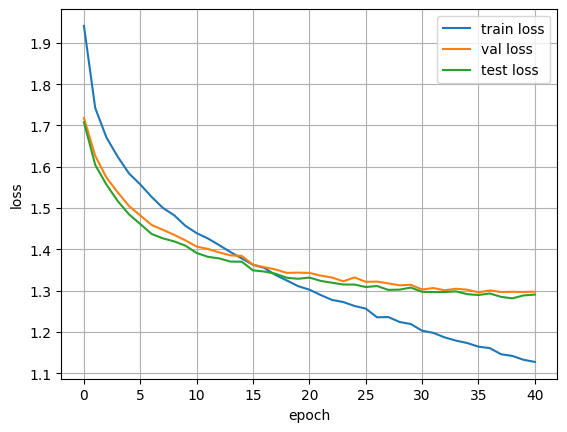

In [98]:
show_loss_through_epochs(arr_losses_train, arr_losses_test, arr_losses_val)

/tmp/ipykernel_7142/3298405776.py:86: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout(h_pad=2)


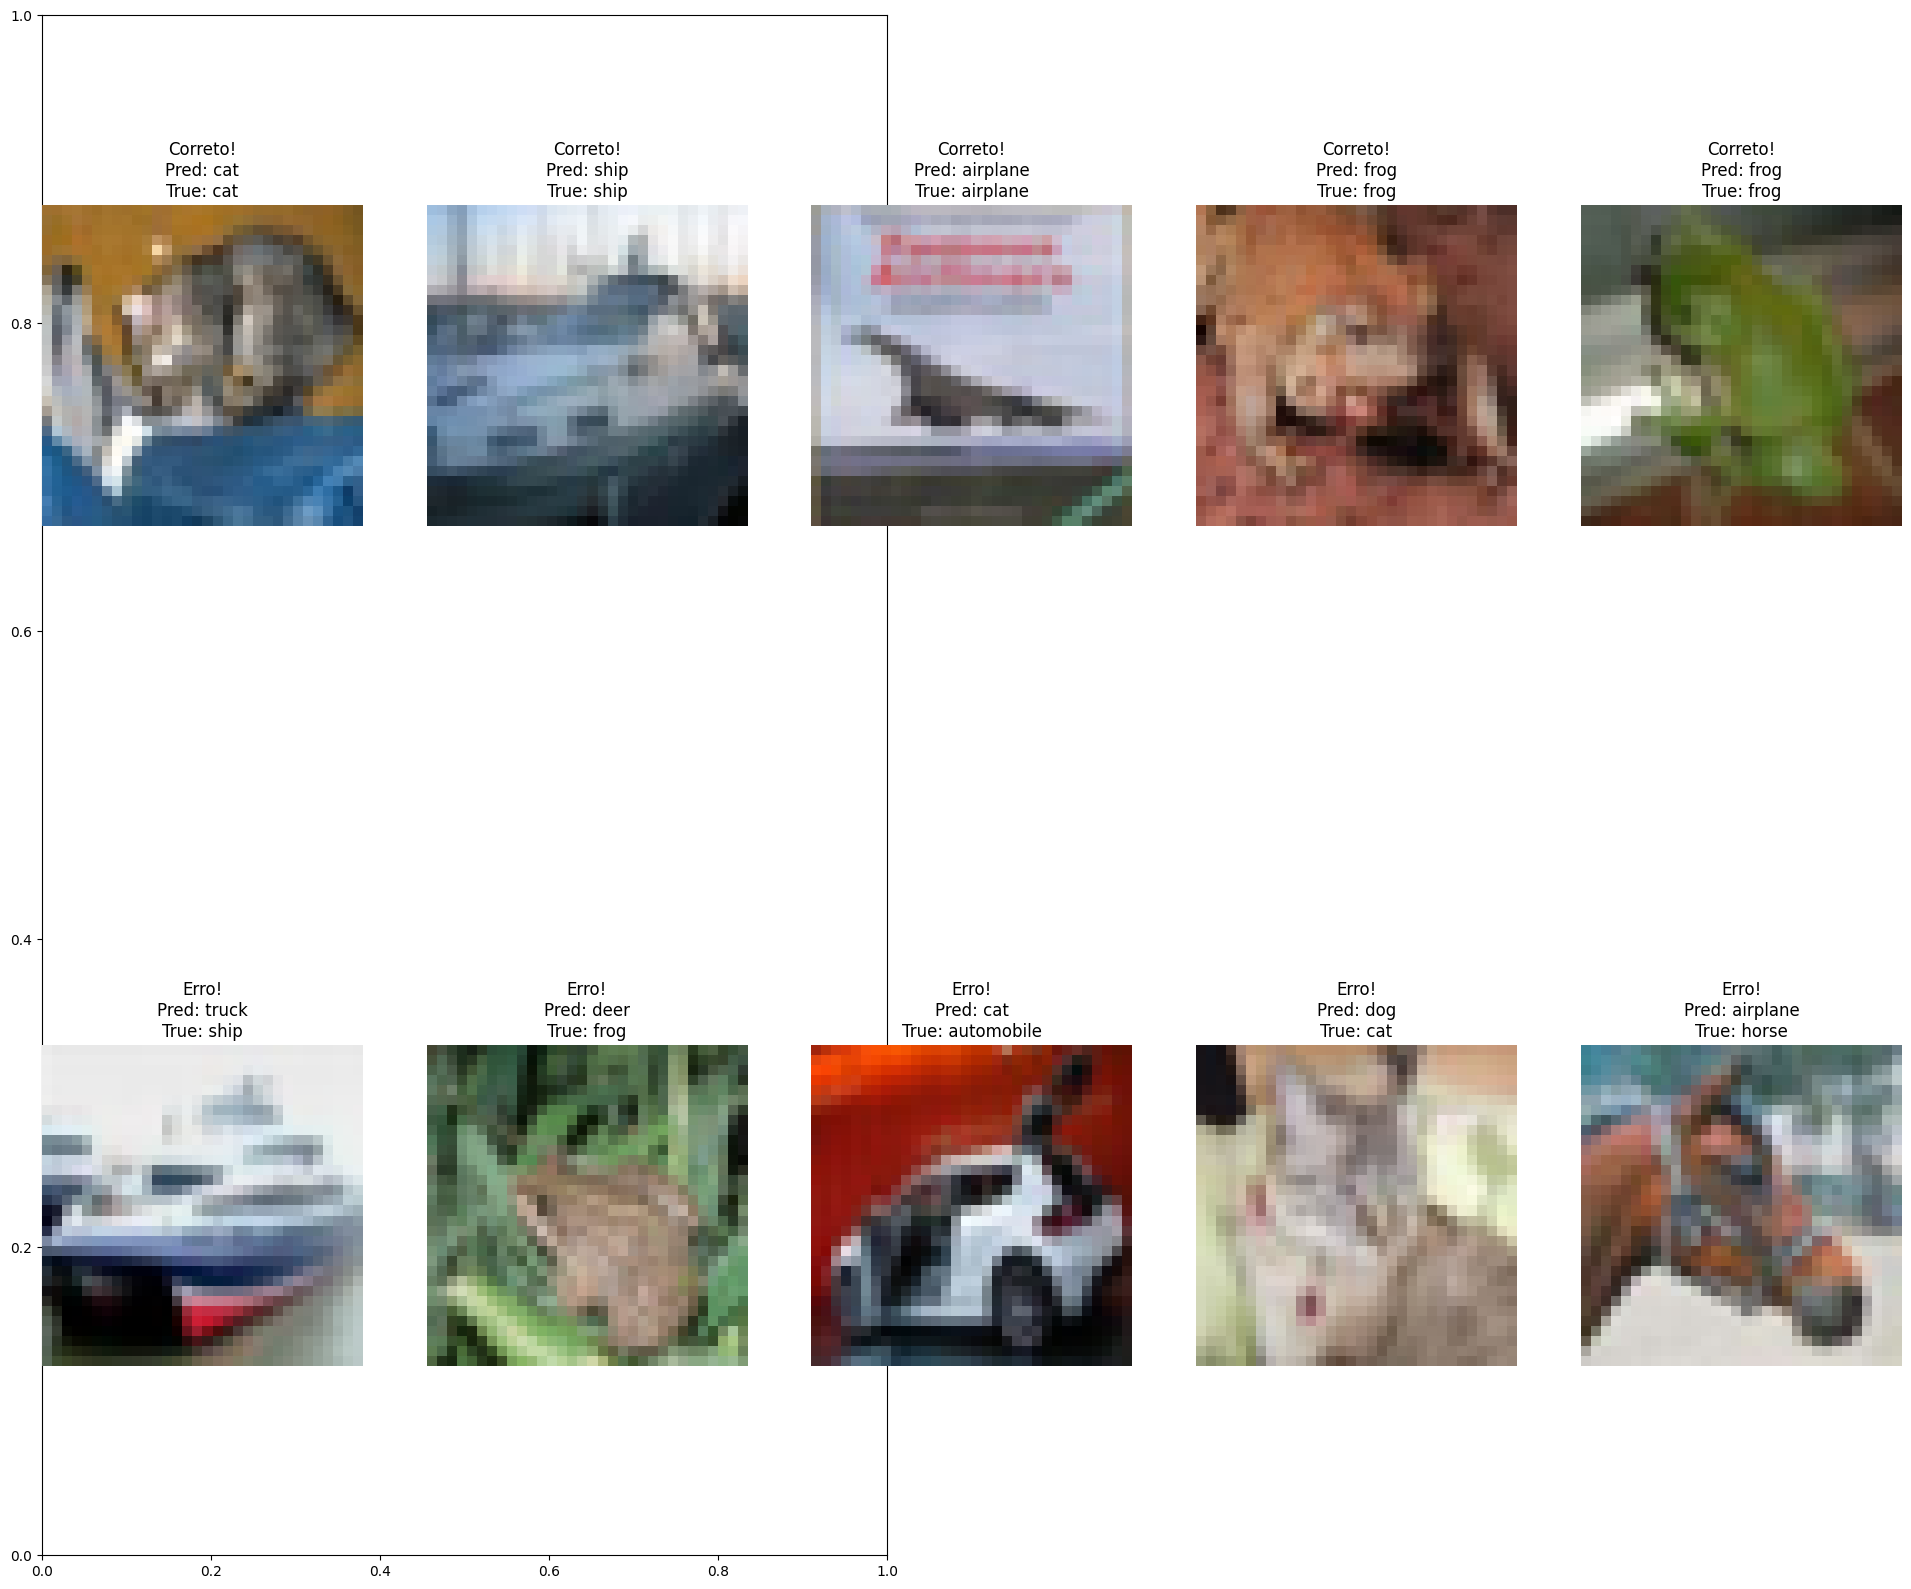

In [102]:
show_predictions(mlp, test_loader, num_samples=5)

In [103]:
mlp.eval()
predictions = []
labels = []

for images, label in test_loader:
  images = images.view(-1,32*32*3).cuda()
  label = label.cuda()

  output = mlp(images)
  _, predicted = torch.max(output,1)

  predictions.extend(predicted.cpu().numpy())
  labels.extend(label.cpu().numpy())

scores = get_scores(labels, predictions)
print(f"Scores of your model\n {scores}\n\n")

Scores of your model
 {'accuracy': 0.551, 'balanced_accuracy': np.float64(0.5509999999999999), 'f1_score': 0.5492578562154636, 'precision': 0.5498466583986955, 'recall': 0.551}




In [101]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck'] # .venvNN/lib/python3.12/site-packages/torchvision/prototype/datasets/_builtin/cifar10.categories

labels = np.array(labels)
predictions = np.array(predictions)

stats = {}

print(f"\n shape dataset teste -> {len(test_dataset)}")
print("\n(repr x acc top1) por classe(conjunto teste):")

for i in range(10):
    mask = labels == i
    class_acc = np.mean(predictions[mask] == labels[mask]) * 100
    num_samples = np.sum(mask)
    class_repr = (num_samples / len(labels)) * 100

    stats[classes[i]] = {
        'acuracia': f"{class_acc:.2f}%",
        'num_amostras': num_samples,
        'representatividade': f"{class_repr:.2f}%"
    }

for classe, metricas in stats.items():
    print(f"\n{classe}:")
    print(f"  Acurácia: {metricas['acuracia']}")
    print(f"  Número de amostras: {metricas['num_amostras']}")
    print(f"  Representatividade: {metricas['representatividade']}")


 shape dataset teste -> 10000

(repr x acc top1) por classe(conjunto teste):

airplane:
  Acurácia: 65.20%
  Número de amostras: 1000
  Representatividade: 10.00%

automobile:
  Acurácia: 66.00%
  Número de amostras: 1000
  Representatividade: 10.00%

bird:
  Acurácia: 39.20%
  Número de amostras: 1000
  Representatividade: 10.00%

cat:
  Acurácia: 40.70%
  Número de amostras: 1000
  Representatividade: 10.00%

deer:
  Acurácia: 48.40%
  Número de amostras: 1000
  Representatividade: 10.00%

dog:
  Acurácia: 40.80%
  Número de amostras: 1000
  Representatividade: 10.00%

frog:
  Acurácia: 65.40%
  Número de amostras: 1000
  Representatividade: 10.00%

horse:
  Acurácia: 59.20%
  Número de amostras: 1000
  Representatividade: 10.00%

ship:
  Acurácia: 69.20%
  Número de amostras: 1000
  Representatividade: 10.00%

truck:
  Acurácia: 56.90%
  Número de amostras: 1000
  Representatividade: 10.00%
